Accurate order forecasts are crucial for planning process, impacting workforce allocation, delivery logistics, inventory management, and supply chain efficiency. By optimizing forecasts, we can minimize waste and streamline operations, making our e-grocery services more sustainable and efficient.



<figure>
        <img src="https://www.rohlik.group/sites/default/files/obsah/frontpage/obrazky/family.png" alt ="Audio Art" style='width:800px;height:500px;'>
        <figcaption>





### Data Loading and Initial Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb

### Load the data

In [2]:
# Load the data
train = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train.csv')
test = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test.csv')
train_calendar = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train_calendar.csv')
test_calendar = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test_calendar.csv')

### Display the first few rows of the train and test datasets

In [3]:
print(train.head())
print(test.head())
print(train_calendar.head())
print(test_calendar.head())

  warehouse        date  orders holiday_name  holiday  shutdown  \
0  Prague_1  2020-12-05  6895.0          NaN        0         0   
1  Prague_1  2020-12-06  6584.0          NaN        0         0   
2  Prague_1  2020-12-07  7030.0          NaN        0         0   
3  Prague_1  2020-12-08  6550.0          NaN        0         0   
4  Prague_1  2020-12-09  6910.0          NaN        0         0   

   mini_shutdown  shops_closed  winter_school_holidays  school_holidays  \
0              0             0                       0                0   
1              0             0                       0                0   
2              0             0                       0                0   
3              0             0                       0                0   
4              0             0                       0                0   

   blackout  mov_change  frankfurt_shutdown  precipitation  snow  \
0         0         0.0                   0            0.0   0.0   
1         

### Summary statistics

In [4]:
print(train.describe())
print(test.describe())

             orders      holiday     shutdown  mini_shutdown  shops_closed  \
count   7340.000000  7340.000000  7340.000000    7340.000000   7340.000000   
mean    5535.443869     0.027248     0.000136       0.000545      0.010899   
std     2182.680279     0.162816     0.011672       0.023340      0.103836   
min      790.000000     0.000000     0.000000       0.000000      0.000000   
25%     4434.000000     0.000000     0.000000       0.000000      0.000000   
50%     5370.000000     0.000000     0.000000       0.000000      0.000000   
75%     7009.250000     0.000000     0.000000       0.000000      0.000000   
max    18139.000000     1.000000     1.000000       1.000000      1.000000   

       winter_school_holidays  school_holidays     blackout   mov_change  \
count             7340.000000      7340.000000  7340.000000  7340.000000   
mean                 0.029973         0.007084     0.000954     0.221499   
std                  0.170524         0.083876     0.030869     0.410

### Merge train data with calendar data

In [5]:
train = pd.merge(train, train_calendar, on=['warehouse', 'date'], how='left')
test = pd.merge(test, test_calendar, on=['warehouse', 'date'], how='left')

### Convert date to datetime format

In [6]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

### Extract date features

In [7]:
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['dayofweek'] = train['date'].dt.dayofweek

test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['dayofweek'] = test['date'].dt.dayofweek

### Fill missing values

In [8]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

### Drop columns that are not useful or cause issues

In [9]:
train.drop(columns=['holiday_name_x', 'holiday_name_y'], inplace=True)
test.drop(columns=['holiday_name_x', 'holiday_name_y'], inplace=True)

### Encode categorical variables

In [10]:
train = pd.get_dummies(train, columns=['warehouse'], drop_first=True)
test = pd.get_dummies(test, columns=['warehouse'], drop_first=True)

### Separate the target column 'orders' from the train DataFrame

In [11]:
y_train = train['orders']
train.drop(columns=['orders'], inplace=True)

### Align the train and test data

In [12]:
train, test = train.align(test, join='inner', axis=1)
train['orders'] = y_train

### Check data types

In [13]:
print(train.dtypes)

date                        datetime64[ns]
holiday_x                            int64
shops_closed_x                       int64
winter_school_holidays_x             int64
school_holidays_x                    int64
id                                  object
holiday_y                            int64
shops_closed_y                       int64
winter_school_holidays_y             int64
school_holidays_y                    int64
year                                 int32
month                                int32
day                                  int32
dayofweek                            int32
warehouse_Budapest_1                  bool
warehouse_Frankfurt_1                 bool
warehouse_Munich_1                    bool
warehouse_Prague_1                    bool
warehouse_Prague_2                    bool
warehouse_Prague_3                    bool
orders                             float64
dtype: object


### Plot the number of orders over time

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


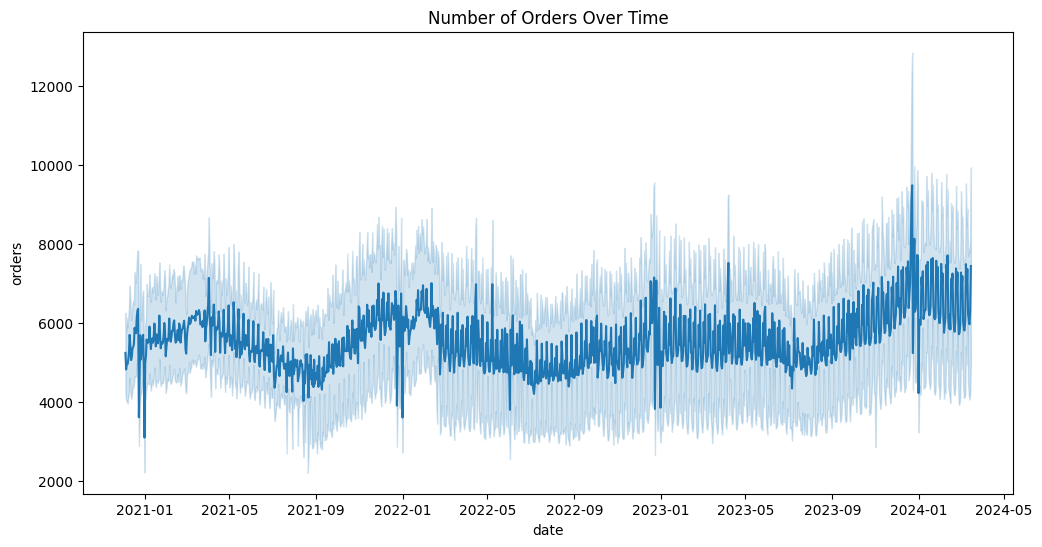

In [14]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=train, x='date', y='orders')
plt.title('Number of Orders Over Time')
plt.show()

### Plot orders distribution

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


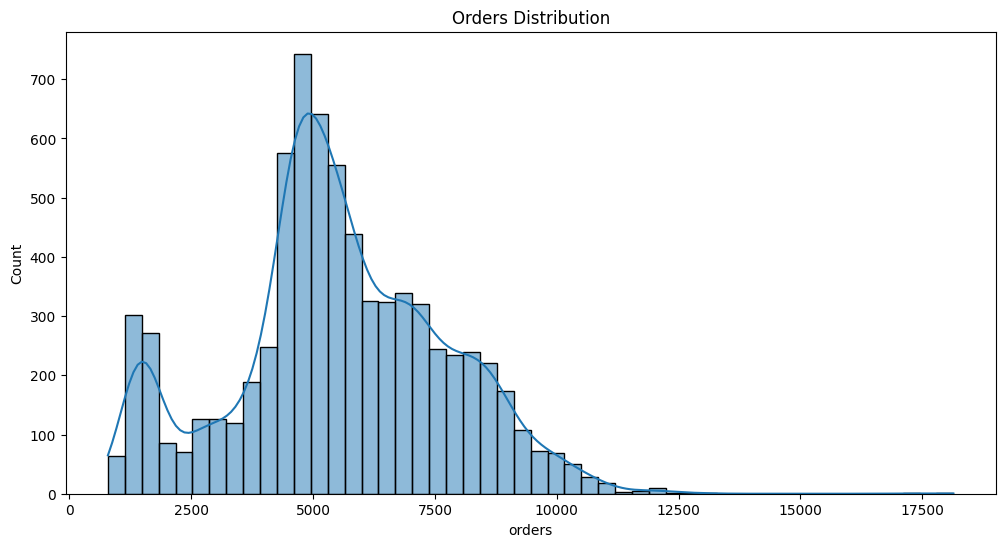

In [15]:
plt.figure(figsize=(12, 6))
sns.histplot(train['orders'], bins=50, kde=True)
plt.title('Orders Distribution')
plt.show()

### Drop the original 'date' and 'id' columns

In [16]:
train.drop(columns=['date'], inplace=True)
test.drop(columns=['date'], inplace=True)

### Separate target variable from features

In [17]:
X = train
X_test = test

### Split train data into features and target

In [18]:
X = train.drop(columns=['orders'])
y = train['orders']

### Split the data into training and validation sets

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Initialize and train the LightGBM model

In [20]:
lgb_model = lgb.LGBMRegressor(objective='regression', n_estimators=1000, learning_rate=0.05)

callbacks = [
    lgb.early_stopping(stopping_rounds=100),
    lgb.log_evaluation(period=10)
]

### Remove 'id' column if exists in the training data

In [21]:
features_to_use = [col for col in X_train.columns if col != 'id']
X_train = X_train[features_to_use]
X_val = X_val[features_to_use]

lgb_model.fit(X_train, y_train, 
              eval_set=[(X_val, y_val)], 
              eval_metric='mape', 
              callbacks=callbacks)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5872, number of used features: 18
[LightGBM] [Info] Start training from score 5512.430518
Training until validation scores don't improve for 100 rounds
[10]	valid_0's mape: 0.301894	valid_0's l2: 2.01941e+06
[20]	valid_0's mape: 0.200384	valid_0's l2: 993537
[30]	valid_0's mape: 0.141372	valid_0's l2: 593768
[40]	valid_0's mape: 0.106917	valid_0's l2: 419814
[50]	valid_0's mape: 0.0863841	valid_0's l2: 332792
[60]	valid_0's mape: 0.0743109	valid_0's l2: 284327
[70]	valid_0's mape: 0.0658907	valid_0's l2: 252013
[80]	valid_0's mape: 0.0596426	valid_0's l2: 221789
[90]	valid_0's mape: 0.0557593	valid_0's l2: 196003
[100]	valid_0's mape: 0.0534907	valid_0's l2: 178389
[110]	vali

LGBMRegressor(learning_rate=0.05, n_estimators=1000, objective='regression')

### Calculate MAPE scores

In [22]:
def calculate_mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

### Training MAPE

In [23]:
train_predictions = lgb_model.predict(X_train)
train_mape = calculate_mape(y_train, train_predictions)

### Align test columns with train columns

In [24]:
train_cols = set(X_train.columns)
val_cols = set(X_val.columns)
test_cols = set(X_test.columns)

### Check differences

In [25]:
missing_in_train_val = train_cols - val_cols
missing_in_train_test = train_cols - test_cols
missing_in_val_train = val_cols - train_cols
missing_in_val_test = val_cols - test_cols
missing_in_test_train = test_cols - train_cols
missing_in_test_val = test_cols - val_cols

print("Columns missing in X_val compared to X_train:", missing_in_val_train)
print("Columns missing in X_test compared to X_train:", missing_in_test_train)

Columns missing in X_val compared to X_train: set()
Columns missing in X_test compared to X_train: {'id'}


In [26]:
common_columns = list(train_cols.intersection(val_cols).intersection(test_cols))
X_test = test[common_columns]

In [27]:
assert set(X_train.columns) == set(X_test.columns), "Columns in X_test do not match with X_train and X_val"

### Make predictions

In [28]:
predictions = lgb_model.predict(X_test)

### Evaluate the model on the validation set

In [29]:
val_predictions = lgb_model.predict(X_val)
mape = mean_absolute_percentage_error(y_val, val_predictions)
print(f'Mean Absolute Percentage Error on validation set: {mape}')

Mean Absolute Percentage Error on validation set: 0.03883780478904273


### Submission Preparation

In [30]:
submission = pd.DataFrame({
    'ID': test['id'],  # Assuming 'id' column exists in test set
    'ORDERS': predictions.round().astype(int)  # Round predictions to nearest integer
})

submission.to_csv('submission.csv', index=False)
print('Submission file created!')

print(submission.head())

Submission file created!
                    ID  ORDERS
0  Prague_1_2024-03-16    5314
1  Prague_1_2024-03-17    5314
2  Prague_1_2024-03-18    6193
3  Prague_1_2024-03-19    5314
4  Prague_1_2024-03-20    5314
